[![](https://img.shields.io/badge/launch-jupyter-blue)](http://localhost:8888/notebooks/01_notebook_as_an_app.ipynb)
[![](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/tuw-geo/tuw_education_notebooks/bee07addf02b7fb6a690f1ee26ed2297f25d3f4c?urlpath=lab%2Ftree%2F01_notebook_as_an_app.ipynb)

![Image from [wikipedia](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)](https://upload.wikimedia.org/wikipedia/commons/d/d4/Thomas_Bayes.gif)

In [1]:
%matplotlib widget

import numpy as np
from eomaps import Maps

from tuw_education_notebooks.view_bayes_flood import view_bayes_flood
from tuw_education_notebooks.calc_bayes_flood import sig0_dc, calc_likelihoods

## From Backscattering to Flood Mapping

This notebook explains how microwave ($\sigma^0$) backscattering (@fig-area) can be used to map the extent of a flood. We replicate in this exercise the work of @bauer-marschallinger_satellite-based_2022 on the TU Wien Bayesian-based flood mapping algorithm.

In the following lines we create a map with EOmaps [@quast_getting_2024] of the $\sigma^0$ backscattering values.

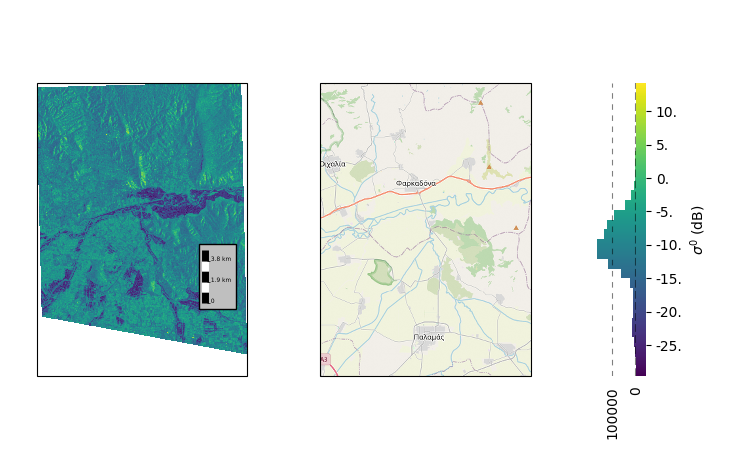

In [2]:
#| label: fig-area
#| fig-cap: 'Area targeted for $\sigma^0$ backscattering is the Greek region of Thessaly, which experienced a major flood in February of 2018.'
m = Maps(ax=121, crs=3857)
m.set_data(data=sig0_dc, x="x", y="y", parameter="SIG0", crs=Maps.CRS.Equi7_EU)
m.plot_map()
m.add_colorbar(label="$\sigma^0$ (dB)", orientation="vertical", hist_bins=30)
m.add_scalebar(n=5)
m2 = m.new_map(ax=122, crs=3857)
m2.set_extent(m.get_extent())
m2.add_wms.OpenStreetMap.add_layer.default()
m.apply_layout(
    {
        'figsize': [7.32, 4.59],
        '0_map': [0.05, 0.18, 0.35, 0.64],
        '1_cb': [0.8125, 0.1, 0.1, 0.8],
        '1_cb_histogram_size': 0.8,
        '2_map': [0.4375, 0.18, 0.35, 0.64]
        }
    )
m.show()

## Microwave Backscattering over Land and Water

Reverend Bayes was concerned with two events, one (the *hypothesis*) occurring before the other (the *evidence*). If we know its cause, it is easy to logically deduce the probability of an effect. However, in this case we want to deduce the probability of a cause from an observed effect, also known as "reversed probability". In the case of flood mapping, we have $\sigma^0$ backscatter observations over land (the effect) and we want to deduce the probability of flooding ($F$) and non-flooding ($NF$). 

In other words, we want to know the probability of flooding $P(F)$ given a pixel's $\sigma^0$:

$$P(F|\sigma^0)$$

and the probability of a pixel being not flooded $P(NF)$ given a certain $\sigma^0$:

$$P(NF|\sigma^0).$$

Bayes showed that these can be deduced from the observation that forward and reversed probability are equal, so that:

$$P(F|\sigma^0)P(\sigma^0) = P(\sigma^0|F)P(F)$$

and

$$P(NF|\sigma^0)P(\sigma^0) = P(\sigma^0|NF)P(NF).$$


The forward probability of $\sigma^0$ given the occurrence of flooding ($P(\sigma^0|F)$) and $\sigma^0$ given no flooding ($P(\sigma^0|NF)$) can be extracted from past information on backscattering over land and water surfaces. As seen in the sketch below (@fig-sat), the characteristics of backscattering over land and water differ considerably.

![Schematic backscattering over land and water. Image from [Geological Survey Ireland](https://www.gsi.ie/images/images/SAR_mapping_land_water.jpg)](https://www.gsi.ie/images/images/SAR_mapping_land_water.jpg){#fig-sat}

## Likelihoods

The so-called likelihoods of $P(\sigma^0|F)$ and $P(\sigma^0|NF)$ can thus be calculated from past backscattering information. Without going into the details of how these likelihoods are calculated, you can **click** on a pixel of the map to plot the likelihoods of $\sigma^0$ being governed by land or water.

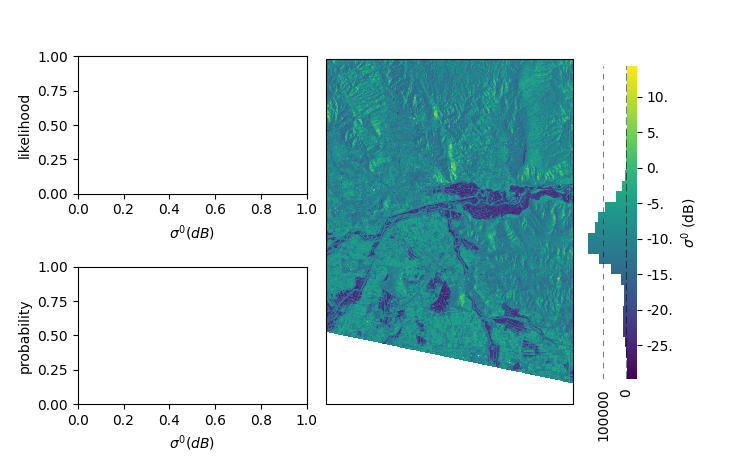

In [3]:
#| label: fig-lik
#| fig-cap: 'Likelihoods for $\sigma^0$ being associated with land or water for 1 pixel in the Greek area of Thessaly. Likelihoods are calculated over a range of $\sigma^0$. The pixel''s observed $\sigma^0$ is given with a vertical line. Click on the map to re-calculate and update this figure for another pixel in the study area. Map created with EOmaps [@quast_getting_2024].'
view_bayes_flood(sig0_dc)

## Posteriors

Having calculated the likelihoods, we can now move on to calculate the probability of (non-)flooding given a pixel's $\sigma^0$. These so-called *posteriors* need one more piece of information, as can be seen in the equation above. We need the probability that a pixel is flooded $P(F)$ or not flooded $P(NF)$. Of course, these are the figures we've been trying to find this whole time. We don't actually have them yet, so what can we do? In Bayesian statistics, we can just start with our best guess. These guesses are called our "priors", because they are the beliefs we hold *prior* to looking at the data. This subjective prior belief is the foundation Bayesian statistics, and we use the likelihoods we just calculated to update our belief in this particular hypothesis. This updated belief is called the "posterior".

Let's say that our best estimate for the chance of flooding versus non-flooding of a pixel is 50-50: a coin flip.  We now can also calculate the probability of backscattering $P(\sigma^0)$, as the weighted average of the water and land likelihoods, ensuring that our posteriors range between 0 to 1.

The following code block shows how we calculate the priors.

In [4]:
def calc_posteriors(water_likelihood, land_likelihood):
    evidence = (water_likelihood * 0.5) + (land_likelihood * 0.5)
    return (water_likelihood * 0.5) / evidence,  (land_likelihood * 0.5) / evidence

We can plot the posterior probabilities of flooding and non-flooding again and compare these to pixel's measured $\sigma^0$. **Click** on a pixel to calculate the posterior probability.

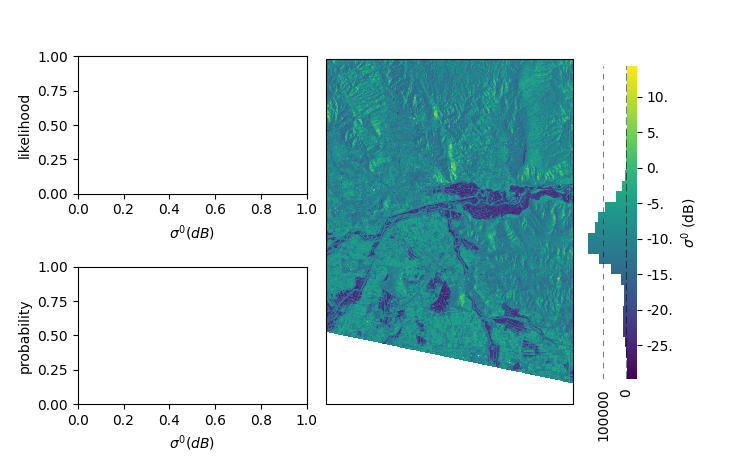

In [5]:
#| label: fig-post
#| fig-cap: 'Posterior probabilities for $\sigma^0$ of 1 pixel being associated with land for water in the Greek area of Thessaly. Click on the map to re-calculate and update this figure for another pixel in the study area. Map created with EOmaps [@quast_getting_2024].'
view_bayes_flood(sig0_dc, calc_posteriors)

## Flood Classification

We are now ready to combine all this information and classify the pixels according to the probability of flooding given the backscatter value of each pixel. Here we just look whether the probability of flooding is higher than non-flooding:

In [6]:
def bayesian_flood_decision(id, sig0_dc):
    nf_post_prob, f_post_prob = calc_posteriors(*calc_likelihoods(id,  sig0_dc))
    return np.greater(f_post_prob, nf_post_prob)

**Click** on a point in the below map to see the likelihoods and posterior distributions (in the left-hand subplots).

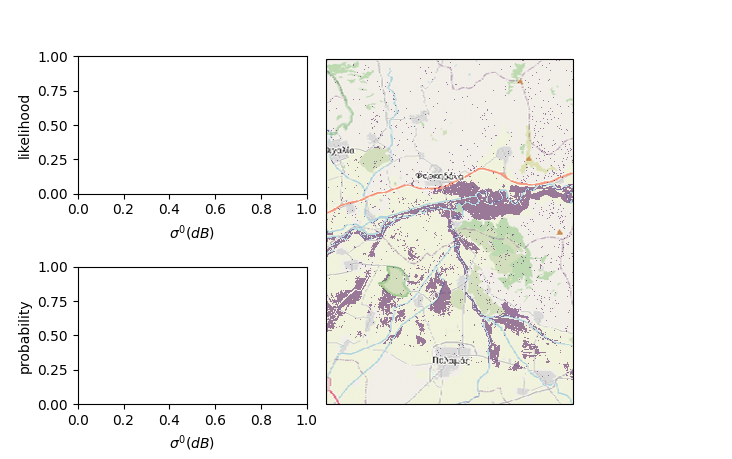

In [7]:
#| label: fig-clas
#| fig-cap: 'Flood extent of the Greek region of Thessaly based on Bayesian probabilities are shown on the map superimposed on an open street map. Click on a pixel to generate the point''s water and land likelihoods as well as the posterior probabilities. Map created with EOmaps [@quast_getting_2024].'
view_bayes_flood(sig0_dc, calc_posteriors, bayesian_flood_decision)